# What is the computational modeling of behavioral data?
Computational models instantiate different ‘algorithmic hypotheses’ about how behavior is generated. There are four main uses in the literatures:
* **Simulation**<br>
Make theortical predictions more precise and testable.
* **Parameter estimation**<br>
A succinct summary of a given dataset<br>
Investigate individual differences<br>
Quantifying effects of interventions<br>
* **Model comparison**<br>
A way to understand which mechanisms underlie behavior.<br>
* **Latent variable inference**<br>
Help to search for neural correlates of the model

<img src="Figure1.png">

# Design a good experiment
* **What scientific question are you asking?**<br>
* **Does your experiment engage the targeted processes?**<br>
* **Will signatures of the targeted processes be evident from simple statistics of the data?**<br>
    In our experience, computational modeling is rarely informative when there is no evidence of an effect in model-independent analyses of behavior.

# Design good models
* **Use heuristics to find a reasonable way to handle information to produce the target behavior**<br>
* **scour the artificial intelligence, computer science, and applied mathematics literature for algorithms that have been used to solve similar problems for artificial agents.**<br>
* **take a Bayes-optimal perspective, to design algorithms that perform optimally given a model of the environment and the task**<br>
<br>
* ***Principles of model design***
  * A computational model should be as simple as possible, but no simpler.
  * A computational model should be interpretable (as much as possible).
  * The models should capture all the hypotheses you plan to test.

## An illustrative example: the multi-armed bandits task
We consider the case in which a participant makes a series of $T$ choices between $K$ slot machines, or `one-armed bandits', to try to maximize their earnings.  If played on trial $t$, each slot machine, $k$, pays out a reward, $r_t$, which is 1 with reward probability, $\mu^k_t$, and otherwise 0.  The reward probabilities are different for each slot machine and are initially unknown to the subject. In the simplest version of the task, the reward probabilities are fixed over time.

The three experimental parameters of this task are: the number of trials, $T$, the number of slot machines, $K$, and the reward probabilities of the different options, $\mu^k_t$, which may or may not change over time. 

<img src="Figures.png">

In [1]:
imatlab_export_fig('print-png')  % Static png figures.
addpath('./2019_MIND_SummerSchool-master');
addpath('./TenSimpleRulesModeling-master');
% We will fix mu throughout (this also means we implicitly fix K = 2 also)
mu = [0.2 0.8]; % option 1 pays out with 20% probability, option 2 with 80% probability

### Model 1: Random responding.
In the first model, we assume that participants do not engage with the task at all and simply press buttons at random, perhaps with a bias for one option over the other. Such random behavior is not uncommon in behavioral experiments, especially when participants have no external incentives for performing well. Modeling such behavior can be important if we wish to identify such `checked out' individuals in a quantitative and reproducible manner, either for exclusion or to study the checked-out behavior itself.  To model this behavior we assume that participants choose between the two options randomly, perhaps with some overall bias for one option over the other.  This bias is captured with a parameter $b$ (which is between 0 and 1) such that the probability of choosing the two options is
\begin{equation}
\label{eq:cp1}
    p^1_t = b \quad \mbox{and}\quad p^2_t = 1-b
\end{equation}
Thus, for two bandits, the random responding model has just one free parameter, controlling the overall bias for option 1 over option 2, $\theta_1 = b$.

In [2]:
%%file simulate_M1random_v1.m

% Specify the random responding model as a function
function [a, r] = simulate_M1random_v1(T, mu, b)

for t = 1:T
    
    % compute choice probabilities
    p = [b 1-b];
    
    % make choice according to choice probababilities
    a(t) = choose(p);
    
    % generate reward based on choice
    r(t) = rand < mu(a(t));
    
end


In [10]:
% simulate the random responding model
[a,r] = simulate_M1random_v1(50, mu, 0.5);

In [7]:
%%file plot_simulation.m

% make a function to plot the output of the simulations
function plot_simulation(ax, a, r)
axes(ax); 
hold on;
time = 1:length(a);
% plot actions
plot(time, a,'.-', 'color', [1 1 1]*0.75, 'markersize', 10)
% color rewarded choice red
plot(time(r==1), a(r==1), '.', 'markersize', 10, 'color', 'r')
ylim([0.8 2.2])
set(gca,'ytick',[1 2],'tickdir','out','fontsize',18)
xlabel('time step')
ylabel('choice')

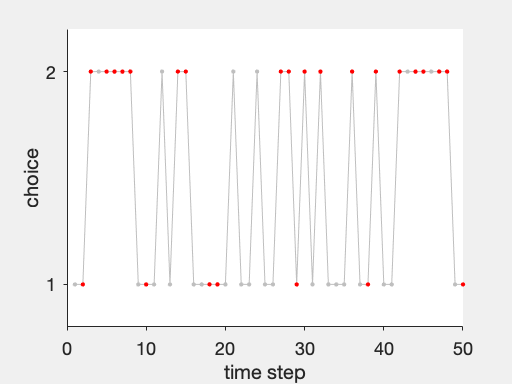

In [11]:
% plot the output
plot_simulation(gca, a, r)

### Model 2: Noisy win-stay-lose-shift.
The win-stay-lose-shift model is one of the simplest models that adapts its behavior according to feedback. Consistent with the name, the model repeats rewarded actions and switches away from unrewarded actions. In the noisy version of the model, the win-stay-lose-shift rule is applied probabilistically, such that the model applies the win-stay-lose-shift rule with probability $1-\epsilon$, and chooses randomly with probability $\epsilon$. In the two-bandit case,  the probability of choosing option $k$ is
\begin{equation}
    p^k_t = \left\{
        \begin{array}{cc}
             1- \epsilon/2 
             & \mbox{if } (c_{t-1} = k \mbox{ and } r_{t-1} = 1) \mbox{ OR } (c_{t-1} \ne k \mbox{ and } r_{t-1} = 0)\\
             \epsilon/2 
             & \mbox{if } (c_{t-1} \ne k \mbox{ and } r_{t-1} = 1) \mbox{ OR } (c_{t-1} = k \mbox{ and } r_{t-1} = 0)
        \end{array}
    \right.
\end{equation}
where $c_t=1,2$ is the choice at trial $t$, and $r_t=0,1$ the reward at trial $t$. While more complex to implement, this model still only has one free parameter, the overall level of randomness, $\theta_2 = \epsilon$.

In [ ]:
%%file simulate_M2WSLS_v1.m

function [a, r] = simulate_M2WSLS_v1(T, mu, epsilon)

% last reward/action (initialize as nan)
rLast = nan;
aLast = nan;

for t = 1:T
    
    % compute choice probabilities
    if isnan(rLast)
        
        % first trial choose randomly
        p = [0.5 0.5];
        
    else
        
        % choice depends on last reward
        if rLast == 1
            
            % win stay (with probability 1-epsilon)
            p = epsilon/2*[1 1];
            p(aLast) = 1-epsilon/2;
            
        else
            
            % lose shift (with probability 1-epsilon)
            p = (1-epsilon/2) * [1 1];
            p(aLast) = epsilon / 2;
            
        end
    end
    
    % make choice according to choice probababilities
    a(t) = choose(p);
    
    % generate reward based on choice
    r(t) = rand < mu(a(t));
    
    
    aLast = a(t);
    rLast = r(t);
end

In [12]:
[a, r] = simulate_M2WSLS_v1(50, mu, 0.1);

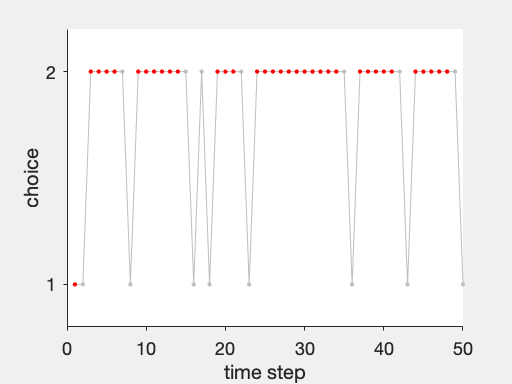

In [13]:
% plot the output
plot_simulation(gca, a, r)

### Model 3: Rescorla Wagner.
In this model, participants first learn the expected value of each slot machine based on the history of previous outcomes and then use these values to make a decision about what to do next.  A simple model of learning is the Rescorla-Wagner learning rule (Rescorla & Wagner, 1972) whereby the value of option $k$, $Q^k_t$ is updated in response to reward $r_t$ according to 
\begin{equation}
\label{eq:learning1}
    Q^k_{t+1} = Q^k_t + \alpha (r_t - Q^k_t)
\end{equation}
where $\alpha$ is the learning rate, which takes a value between 0 and 1 and captures the extent to which the prediction error, $(r_t - Q^k_t)$, updates the value.  For simplicity, we assume that the initial value, $Q^k_0$, is zero, although it is possible to treat the $Q^k_0$ as a free parameter of the model.

A simple model of decision making is to assume that participants use the options' values to guide their decisions, choosing the most valuable option most frequently, but occasionally making 'mistakes' (or exploring) by choosing a low value option.  One choice rule with these properties is known as the 'softmax' choice rule, which chooses option $k$ with probability 
\begin{equation}
\label{eq:decision1}
    p^k_t = \frac{\exp(\beta Q^k_t)}{\sum_{i=1}^K \exp(\beta Q^i_t)}
\end{equation}
where $\beta$ is the 'inverse temperature' parameter that controls the level of stochasticity in the choice, ranging from $\beta = 0$ for completely random responding and $\beta = \infty$ for deterministically choosing the highest value option.

Combining the learning and decision rules gives a simple model of decision making in this task with two free parameters: the learning rate, $\alpha$, and the inverse temperature $\beta$.  That is, in our general notation, for this model $\theta_3 = (\alpha, \beta)$.

In [ ]:
%%file simulate_M3RescorlaWagner_v1.m

function [a, r, Q_stored] = simulate_M3RescorlaWagner_v1(T, mu, alpha, beta)

Q = [0.5 0.5];

for t = 1:T
    
    % store values
    Q_stored(:,t) = Q;
    
    % compute choice probabilities
    p = exp(beta*Q) / sum(exp(beta*Q));
    
    % make choice according to choice probababilities
    a(t) = choose(p);
    
    % generate reward based on choice
    r(t) = rand < mu(a(t));
    
    % update values
    delta = r(t) - Q(a(t));
    Q(a(t)) = Q(a(t)) + alpha * delta;

end

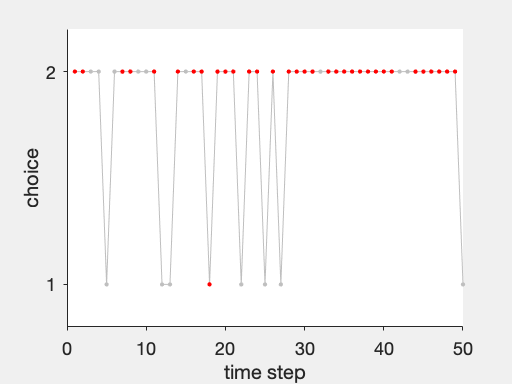

In [15]:
[a, r, Q] = simulate_M3RescorlaWagner_v1(50, mu, 0.1, 5);
plot_simulation(gca, a, r)

In [ ]:
%%file plot_values.m

function plot_values(ax, Q, a, mu)
axes(ax); 
hold on;
l = plot(Q');
set(l, 'linewidth', 2)
plot([0 length(a)], [mu(1) mu(1)], 'k--')
plot([0 length(a)], [mu(2) mu(2)], 'k--')
ylim([0 1])
set(ax, 'tickdir', 'out', 'fontsize', 18, 'box', 'off')
ylabel('values')
xlabel('time step')
legend({'option 1' 'option 2'}, 'location', 'southwest')

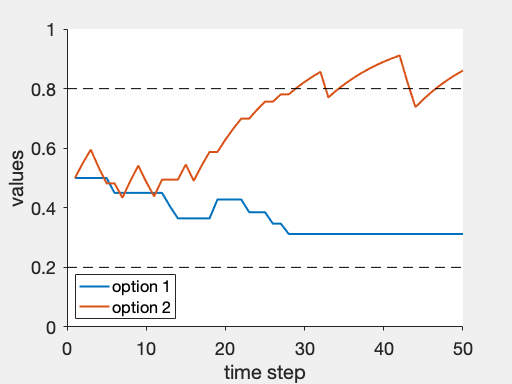

In [16]:
% we can also plot the values from this model
plot_values(gca, Q, a, mu)

### Model 4: Choice kernel 
This model tries to capture the tendency for people to repeat their previous actions. In particular, we assume that participants compute a `choice kernel,' $CK^k_t$, for each action, which keeps track of how frequently they have chosen that option in the recent past.  This choice kernel updates in much the same way as the values in the Rescorla-Wagner rule, i.e. according to
\begin{equation}
\label{eq:CK1}
    CK^k_{t+1} = CK^k_t + \alpha_c (a^k_t - CK^k_t)
\end{equation}
where $a^k_t = 1$ if option $k$ is played on trial $t$, otherwise $a^k_t = 0$, and $\alpha_c$ is the choice-kernel learning rate.  For simplicity we assume that the initial value of the choice kernel is always zero, although, like the initial $Q$-value in the Rescorla-Wagner model, this could be a parameter of the model. Note that with $\alpha_c=1$, this model is very similar to model 2 (win-stay-lose-shift).  From there, we assume that each option is chosen according to
\begin{equation}
\label{eq:CKdecision1}
    p^k_t = \frac{\exp(\beta_c CK^k_t)}{\sum_{i=1}^K \exp(\beta_c CK^i_t)}
\end{equation}
where $\beta_c$ is the inverse temperature associated with the choice kernel.

Combining the choice kernel with the  decision rule gives a simple model of decision making in this task with two free parameters: the choice-kernel learning rate, $\alpha_c$, and the choice-kernel inverse temperature $\beta_c$.  That is, in our general notation, for this model $\theta_4 = (\alpha_c, \beta_c)$.

In [ ]:
%%file simulate_M4ChoiceKernel_v1.m

function [a, r, CK_stored] = simulate_M4ChoiceKernel_v1(T, mu, alpha_c, beta_c)

CK = [0 0];

for t = 1:T
    
    % store choice kernel
    CK_stored(:,t) = CK;
    
    % compute choice probabilities
    p = exp(beta_c*CK) / sum(exp(beta_c*CK));
    
    % make choice according to choice probababilities
    a(t) = choose(p);
    
    % generate reward based on choice
    r(t) = rand < mu(a(t));
    
    % update choice kernel
    CK = (1-alpha_c) * CK;
    CK(a(t)) = CK(a(t)) + alpha_c * 1;
            
    
end

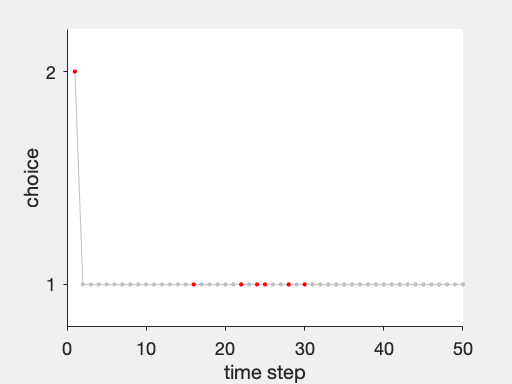

In [19]:
[a, r, CK] = simulate_M4ChoiceKernel_v1(50, mu, 0.1, 5);
plot_simulation(gca, a, r)

In [ ]:
%%file plot_kernel.m

function plot_kernel(ax, CK)

axes(ax); hold on;
l = plot(CK');
set(l, 'linewidth', 2)
ylim([0 1])
set(gca, 'tickdir', 'out', 'fontsize', 18, 'box', 'off')
ylabel('choice kernel')
xlabel('time step')
legend({'option 1' 'option 2'}, 'location', 'northwest')

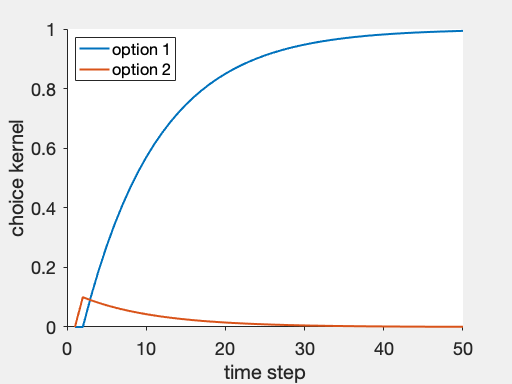

In [20]:
% we can also plot the value of the choice kernel from this model
plot_kernel(gca, CK)

### Model 5: Rescorla Wagner + choice kernel

Finally, our most complex model mixes the reinforcement learning model with the choice kernel model.  In this model, the values update according to the Rescorla-Wagner rule in Model 3, while the choice kernel updates according to the equations for Model 4.  The terms are then combined to compute the choice probabilities as
\begin{equation}
\label{eq:cp5}
    p^k_t = \frac{\exp(\beta Q^k_t + \beta_c CK^k_t)}{\sum_{i=1}^K \exp(\beta Q^i_t + \beta_c CK^i_t)}
\end{equation}
This most complex model has four free parameters, i.e. $\theta_5 = (\alpha, \beta, \alpha_c, \beta_c)$

In [ ]:
%%file simulate_M5RWCK_v1.m

function [a, r, Q_stored, CK_stored] = simulate_M5RWCK_v1(T, mu, alpha, beta, alpha_c, beta_c)

Q = [0.5 0.5];
CK = [0 0];

for t = 1:T
    
    Q_stored(:,t) = Q;
    CK_stored(:,t) = CK;
    
    % compute choice probabilities
    V = beta * Q + beta_c * CK;
    p = exp(V) / sum(exp(V));
                
    % make choice according to choice probababilities
    a(t) = choose(p);
    
    % generate reward based on choice
    r(t) = rand < mu(a(t));
    
    % update values
    delta = r(t) - Q(a(t));
    Q(a(t)) = Q(a(t)) + alpha * delta;

    % update choice kernel
    CK = (1-alpha_c) * CK;
    CK(a(t)) = CK(a(t)) + alpha_c * 1;
            
    
end

In [21]:
[a, r, Q, CK] = simulate_M5RWCK_v1(50, mu, 0.1, 5, 0.1, 1);

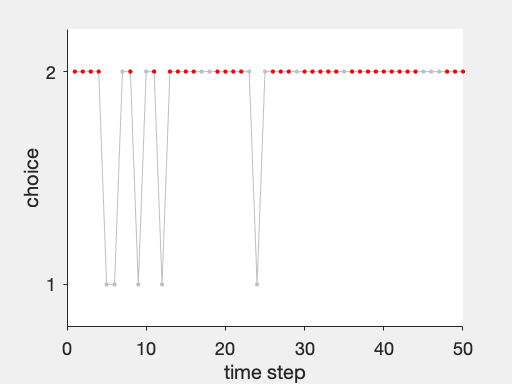

In [22]:
plot_simulation(gca, a, r)

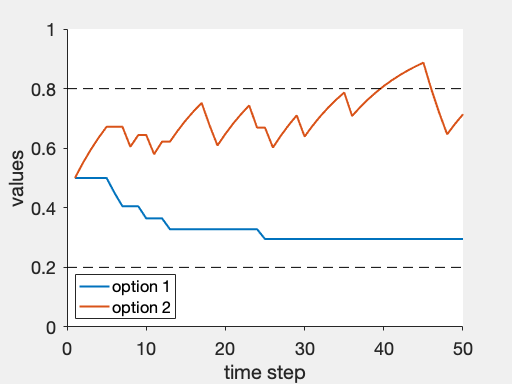

In [23]:
plot_values(gca, Q, a, mu)

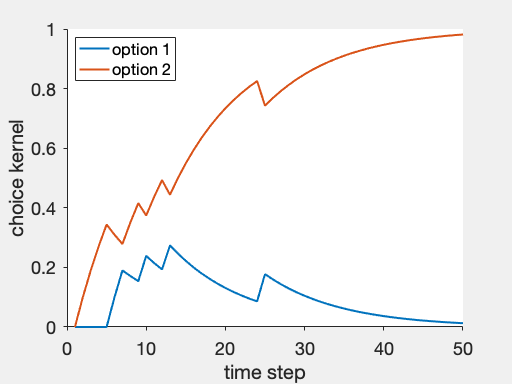

In [24]:
plot_kernel(gca, CK)

## Define model-independent measures that capture key aspects of the processes you are trying to model

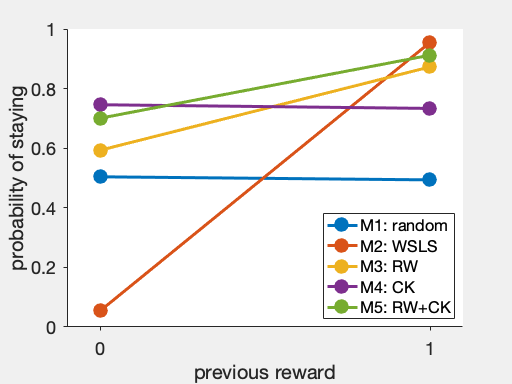

In [4]:
%%
% set up colors
global AZred AZblue AZcactus AZsky AZriver AZsand AZmesa AZbrick

AZred = [171,5,32]/256;
AZblue = [12,35,75]/256;
AZcactus = [92, 135, 39]/256;
AZsky = [132, 210, 226]/256;
AZriver = [7, 104, 115]/256;
AZsand = [241, 158, 31]/256;
AZmesa = [183, 85, 39]/256;
AZbrick = [74, 48, 39]/256;



% experiment parameters
T   = 100;         % number of trials
mu  = [0.2 0.8];    % mean reward of bandits

% number of repetitions for simulations
Nrep = 110;

% Model 1: Random responding
for n = 1:Nrep
    b = 0.5;
    [a, r] = simulate_M1random_v1(T, mu, b);
    sim(1).a(:,n) = a;
    sim(1).r(:,n) = r;
end

% Model 2: Win-stay-lose-shift
for n = 1:Nrep
    epsilon = 0.1;
    [a, r] = simulate_M2WSLS_v1(T, mu, epsilon);
    sim(2).a(:,n) = a;
    sim(2).r(:,n) = r;
end
% Model 3: Rescorla Wagner
for n = 1:Nrep
    alpha = 0.1;
    beta = 5;
    [a, r] = simulate_M3RescorlaWagner_v1(T, mu, alpha, beta);
    sim(3).a(:,n) = a;
    sim(3).r(:,n) = r;
end

% Model 4: Choice kernel
for n = 1:Nrep
    alpha_c = 0.1;
    beta_c = 3;
    [a, r] = simulate_M4ChoiceKernel_v1(T, mu, alpha_c, beta_c);
    sim(4).a(:,n) = a;
    sim(4).r(:,n) = r;
end

% Model 5: Rescorla-Wagner + choice kernel
for n = 1:Nrep
    alpha = 0.1;
    beta = 5;
    alpha_c = 0.1;
    beta_c = 1;
    [a, r] = simulate_M5RWCK_v1(T, mu, alpha, beta, alpha_c, beta_c);
    sim(5).a(:,n) = a;
    sim(5).r(:,n) = r;
end


%% win-stay-lose-shift analysis
for i = 1:length(sim)
    for n = 1:Nrep
        sim(i).wsls(:,n) = analysis_WSLS_v1(sim(i).a(:,n)', sim(i).r(:,n)');
    end
    wsls(:,i) = nanmean(sim(i).wsls,2);
end

%% Plot WSLS behavior for all models
figure(1); clf; hold on;
l = plot([0 1], wsls);
ylim([0 1])
set(l, 'marker', '.', 'markersize', 50, 'linewidth', 3)


legend({'M1: random' 'M2: WSLS' 'M3: RW' 'M4: CK' 'M5: RW+CK'}, ...
    'location', 'southeast')
xlabel('previous reward')
ylabel('probability of staying')

set(gca, 'xtick', [0 1], 'tickdir', 'out', 'fontsize', 18, 'xlim', [-0.1 1.1])

# Model fitting

A key component of computational modeling is estimating the values of the parameters that best describe your behavioral data. While there are a number of different ways of estimating parameters, here we focus on the maximum-likelihood approach, although almost all of our points apply to other methods such as Markov Chain Monte Carlo approaches (e.g. Lee and Wagenmakers 2014). Mathematical details, as well as additional discussion of other approaches to model fitting can be found in the Appendix of (Wilson and Collins 2019).

In the maximum likelihood approach to model fitting, our goal is to find the parameter values of model $m$, $\hat{\theta}_m^{MLE}$, that maximize the likelihood of the data, $d_{1:T}$, given the parameters, $p(d_{1:T} | \theta_m, m)$. Maximizing the likelihood is equivalent to maximizing the log of the likelihood,  $LL = \log p(d_{1:T} | \theta_m, m)$, which is numerically more tractable. A simple mathematical derivation shows that this log-likelihood can be written in terms of the choice probabilities of the individual model as
\begin{equation}
\label{eq:LL}
	LL = \log p(d_{1:T} | \theta_m, m) 
	= \sum_{t=1}^T \log p(c_t | d_{1:t-1}, s_t, \theta_m, m)
\end{equation}
where $p(c_t | d_{1:t-1}, s_t, \theta_m, m)$ is the probability of each individual choice given the parameters of the model and available information up to that choice, which is at the heart of the definition of each model. 
## Computing the log likelihood

In practice, the likelihood is simply a function of the data and parameters that we can define in Matlab for each of the models under consideration. In this notebook we will focus on the Model 3, the Rescorla Wagner model. For this model, we can write a likelihood function as:

In [29]:
%%file simulate_M3RescorlaWagner_v1.m

function [a, r] = simulate_M3RescorlaWagner_v1(T, mu, alpha, beta)

Q = [0.5 0.5];

for t = 1:T
    
    % compute choice probabilities
    p = exp(beta*Q) / sum(exp(beta*Q));
    
    % make choice according to choice probababilities
    a(t) = choose(p);
    
    % generate reward based on choice
    r(t) = rand < mu(a(t));
    
    % update values
    delta = r(t) - Q(a(t));
    Q(a(t)) = Q(a(t)) + alpha * delta;

end

In [30]:
%%file lik_M3RescorlaWagner_v1.m

function NegLL = lik_M3RescorlaWagner_v1(a, r, alpha, beta)

Q = [0.5 0.5];

T = length(a);

% loop over all trial
for t = 1:T
    
    % compute choice probabilities
    p = exp(beta*Q) / sum(exp(beta*Q));
    
    % compute choice probability for actual choice
    choiceProb(t) = p(a(t));
    
    % update values
    delta = r(t) - Q(a(t));
    Q(a(t)) = Q(a(t)) + alpha * delta;

end

% compute negative log-likelihood
NegLL = -sum(log(choiceProb));

Note that the output of this function is the negative of the log-likelihood not the true log likelihood. This is because Matlab's optimization algorithms are setup to minimize functions not maximize them. Obviously minimizing the negative log-likelihood is the same as maximizing the log-likelihood.

Note also the similarity between the code for the likelihood function and the code for simulating the same model (see below). Choice probabilities and values are computed in exactly the same way. The only difference is that the simulation function samples choices and rewards while the likelihood function takes choices and rewards as inputs and computes the probability that each choice was made for given parameter values.

We can now use the log-likelihood function to compute the (negative) log-likelihood for some simulated choices

In [4]:
% simulate choices from Model 3
T = 50;
mu = [0.2 0.8];
alpha = 0.1;
beta = 5;
[a, r] = simulate_M3RescorlaWagner_v1(50, mu, alpha, beta);

% evaluate negative log-likelihood for this simulated dataset at some other parameter values
alpha_hat = 0.2;
beta_hat = 10;
NegLL = lik_M3RescorlaWagner_v1(a, r, alpha_hat, beta_hat)


NegLL =

   30.7033



## Fitting 
In principle, finding the maximum likelihood parameters is as 'simple' as maximizing $LL$. In practice, of course, finding the maximum of a function is not a trivial process. The simplest approach, a brute force search of the entire parameter space. Let's try that for our simulated data set.  For simplicity we will assume that we know beta but don't know alpha ...

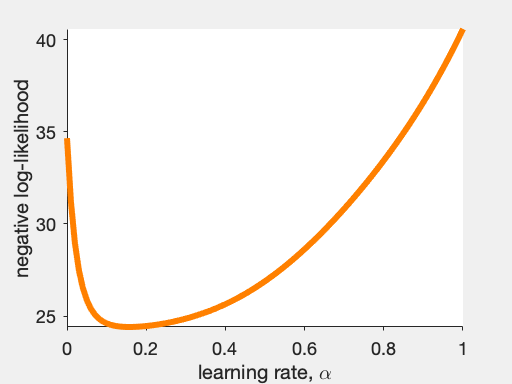

In [7]:
alpha_vals = [0:0.01:1];
for i = 1:length(alpha_vals)
    nLL(i) = lik_M3RescorlaWagner_v1(a, r, alpha_vals(i), beta);
end

plot(alpha_vals, nLL, 'linewidth', 6, 'color', [1 0.5 0]);
set(gca, 'box', 'off', 'fontsize', 18, 'tickdir', 'out')
xlabel('learning rate, \alpha')
ylabel('negative log-likelihood')

Unfortunately, the brute force approach is unfeasible outside of the simplest cases (e.g. one or two parameters with tight bounds) due to the high computational costs of evaluating the likelihood function at a large number of points. 

Fortunately, a number of tools exist for finding local maxima (and minima) of functions quickly using variations on gradient ascent (or descent). For example, Matlab's fmincon function can use a variety of sophisticated optimization algorithms to find the minimum of a function. So long as one remembers to feed fmincon the negative log-likelihood, using tools such as fmincon can greatly speed up model fitting. 

In practice, in many cases using fmincon for fitting model parameters comes down to five lines of code specifying: (1) the function you wish to minimize, (2) the starting values of the parameters for the search algorithm, (3) the lower bounds for each parameter, (4) the upper bounds for each parameter, and (5) the call to fmincon.  

For Model 3, this plays out as:

In [8]:
% define a function handle for the likelihood function 
obFunc = @(x) lik_M3RescorlaWagner_v1(a, r, x(1), x(2));

% define the initial conditions for the parameter search
X0 = [rand exprnd(1)];

% lower bounds for parameters
LB = [0 0];

% upper bounds for parameters
UB = [1 inf];

% call fmincon to get fit parameters and NegLL at minimum
[Xfit, NegLL] = fmincon(obFunc, X0, [], [], [], [], LB, UB)


Local minimum found that satisfies the constraints.

Optimization completed because the objective function is non-decreasing in 
feasible directions, to within the default value of the optimality tolerance,
and constraints are satisfied to within the default value of the constraint tolerance.




Xfit =

    0.2245    4.2694


NegLL =

   24.3488



## Parameter recovery
Before reading too much into the best fitting parameter values, $\theta_m^{MLE}$, it is important to check whether the fitting procedure gives meaningful parameter values in the best case scenario - i.e. when fitting fake data where the 'true' parameter values are known. Such a procedure is known as 'Parameter Recovery,' and is a crucial part of any model-based analysis.  

In principle, the recipe for parameter recovery is quite simple. First, simulate fake data with known parameter values. Next, fit the model to this fake data to try to 'recover' the parameters. Finally, compare the recovered parameters to their true values. In a perfect world the simulated and recovered parameters will be tightly correlated, with no bias. If there is only a weak correlation between simulated and recovered parameters and/or a significant bias, then this is an indication that there is either a bug in your code (often the case) or the experiment is underpowered to assess this model (also often the case!).

In [ ]:
%%file fit_M3RescorlaWagner_v1.m

% To make parameter recovery code simpler to read define a function for fitting Model 3

function [Xfit, LL, BIC] = fit_M3RescorlaWagner_v1(a, r)

obFunc = @(x) lik_M3RescorlaWagner_v1(a, r, x(1), x(2));

X0 = [rand exprnd(1)];
LB = [0 0];
UB = [1 inf];

options = optimoptions('fmincon','Display','off'); % this turns verbose mode off
[Xfit, NegLL] = fmincon(obFunc, X0, [], [], [], [], LB, UB, [], options);




LL = -NegLL;
BIC = length(X0) * log(length(a)) + 2*NegLL;

In [12]:
% experiment parameters
T   = 50;         % number of trials
mu  = [0.2 0.8];    % mean reward of bandits

% Model 3: Rescorla Wagner
for count = 1:100
    alpha = rand;
    beta = exprnd(10);
    [a, r] = simulate_M3RescorlaWagner_v1(T, mu, alpha, beta);
    [Xf, LL, BIC] = fit_M3RescorlaWagner_v1(a, r);
    
    Xsim(1,count) = alpha;
    Xsim(2,count) = beta;
    Xfit(1,count) = Xf(1);
    Xfit(2,count) = Xf(2);
    
end

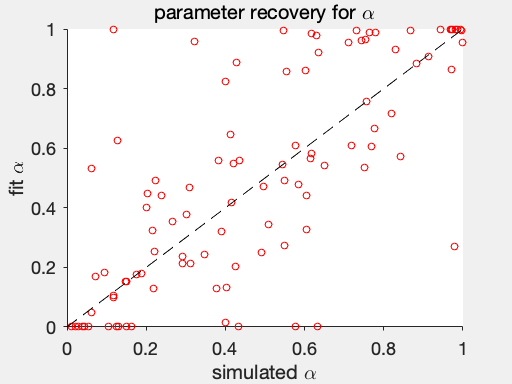

In [13]:
% parameter recovery for alpha
hold on;
plot(Xsim(1,:), Xfit(1,:),'o', 'markersize', 7, 'color', 'r')
plot([0 1], [0 1], 'k--')

xlabel('simulated \alpha'); 
ylabel('fit \alpha'); 
title('parameter recovery for \alpha')
set(gca, 'tickdir','out', 'fontsize', 18)

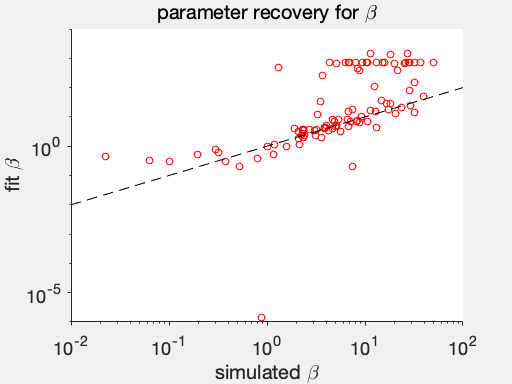

In [11]:
% parameter recovery for beta
hold on;
plot(Xsim(2,:), Xfit(2,:),'o', 'markersize', 7, 'color', 'r')

xlabel('simulated \beta'); 
ylabel('fit \beta'); 
title('parameter recovery for \beta')
set(gca, 'tickdir','out', 'fontsize', 18, 'xscale', 'log', 'yscale', 'log')
xl = get(gca,'xlim');
plot(xl, xl, 'k--')

Is that good parameter recovery?  How can we improve it?

If there is only a weak correlation between simulated and recovered parameters and/or a significant bias, then this is an indication that there is either a bug in your code (which from our own experience we suggest is fairly likely) or the experiment is underpowered to assess this model.

# Model comparison

In model comparison, our goal is to determine which model, out of a set of possible models, is most likely to have generated the data. There are a number of different ways to make this comparison which are briefly summarized in the Appendix of (Wilson and Collins, 2019). Here we focus on the most common method which is related to the log-likelihood.

A simplistic approach to model comparison would be to compare the log-likelihoods of each model at the best fitting parameter settings, $p(d_{1:T} | \hat{\theta}_m, m)$.  However, if the data, $d_{1:T}$, used to evaluate the log-likelihood are the same data used to fit the parameters, then this approach will lead to overfitting, as the model with most free parameters will almost always fit this 'training' data best.  As an extreme example, consider the case of a model with one 'parameter' per choice which is the identity of the choice the person actually made.  Such a 'model' would fit the data perfectly, but would of course tell us nothing about how the choices were actually determined and make no predictions about what choices would be made in a different setting. Overfitting is a problem in that it decreases the generalizability of the model. 

One way to avoid overfitting is to perform cross-validation: by measuring fit on held-out data, we directly test generalizability. However, this is not always possible for practical reasons (number of samples) or more fundamental ones (dependence between data points). Thus, other methods mitigate the risk of overfitting by approximately accounting for the degrees of freedom in the model. Here we focus on one of the simplest methods, the Bayes Information Criterion, $BIC$, which has an explicit penalty for free parameters.  
\begin{equation}
\label{eq:BIC}
    BIC = -2 \log \hat{LL} + k_m \log(T)
\end{equation}
where $\hat{LL}$ is the log-likelihood value at the best fitting parameter settings, and $k_m$ is the number of parameters in model $m$.  The model with the smallest $BIC$ score is the model that best fits the data.  Thus, the positive effect of $k_m$ in the last term corresponds to a penalty for models with large numbers of parameters. 

In [ ]:
%%file fit_all_v1.m

% make a function to fit all models to a set of data

function [BIC, iBEST, BEST] = fit_all_v1(a, r)

[~, ~, BIC(1)] = fit_M1random_v1(a, r);
[~, ~, BIC(2)] = fit_M2WSLS_v1(a, r);
[~, ~, BIC(3)] = fit_M3RescorlaWagner_v1(a, r);
[~, ~, BIC(4)] = fit_M4CK_v1(a, r);
[~, ~, BIC(5)] = fit_M5RWCK_v1(a, r);

[M, iBEST] = min(BIC);
BEST = BIC == M;
BEST = BEST / sum(BEST);

In [14]:
% generate some data from Model 3 and fit it with all models
T = 50;
mu = [0.2 0.8];
alpha = 0.1;
beta = 5;
[a, r] = simulate_M3RescorlaWagner_v1(50, mu, alpha, beta);

[BIC, iBEST, BEST] = fit_all_v1(a, r)


BIC =

   47.8790   68.5604   45.9836   48.2126   53.6438


iBEST =

     3


BEST =

     0     0     1     0     0



Is this good? Let's repeat the process multiple times and count how many times the data are best fit with model 3 ...

In [15]:
% simulate and fit multiple times with random parameter settings each time

T = 50;
mu = [0.2 0.8];
N_repeats = 10;
% note this may take a minute or so to run if N_repeats is high

COUNT = zeros(1,5);

for n = 1:N_repeats
    alpha = rand;
    beta = 1+exprnd(1);
    
    [a, r] = simulate_M3RescorlaWagner_v1(T, mu, alpha, beta);

    [BIC, iBEST, BEST] = fit_all_v1(a, r);
    COUNT = COUNT + BEST;
end
COUNT


COUNT =

     4     2     4     0     0



In [16]:
% can improve performance by designing a better experiment - in this case just adding more trials

T = 1000;
mu = [0.2 0.8];
N_repeats = 10;
% note this may take a minute or so to run if N_repeats is high

COUNT = zeros(1,5);

for n = 1:N_repeats
    alpha = rand;
    beta = 1+exprnd(1);
    
    [a, r] = simulate_M3RescorlaWagner_v1(T, mu, alpha, beta);

    [BIC, iBEST, BEST] = fit_all_v1(a, r);
    COUNT = COUNT + BEST;
end
COUNT


COUNT =

     1     0     9     0     0



## Making a confusion matrix to validate model comparison
Just as parameter fitting should be validated by parameter recovery on simulated data, so should model comparison be validated by model recovery on simulated data. More specifically, this process involves simulating data from all models (with a range of parameter values as in the case of parameter recovery) and then fitting that data with all models to determine the extent to which fake data generated from model $A$ is best fit by model $A$ as opposed to model $B$.  This process can be summarized in a confusion matrix that quantifies the probability that each model is the best fit to data generated from the other models.  In a perfect world the confusion matrix will be the identity matrix, but in practice this is not always the case e.g. (Wilson & Niv, 2012).

In [17]:
% generate a confusion matrix for this task
% this can take a while, start with N_repeats small!


CM = zeros(5);

T = 50;
mu = [0.2 0.8];

N_repeats = 10;


for count = 1:N_repeats
    
    % Model 1
    b = rand;
    [a, r] = simulate_M1random_v1(T, mu, b);
    [BIC, iBEST, BEST] = fit_all_v1(a, r);
    CM(1,:) = CM(1,:) + BEST;
    
    % Model 2
    epsilon = rand;
    [a, r] = simulate_M2WSLS_v1(T, mu, epsilon);
    [BIC, iBEST, BEST] = fit_all_v1(a, r);
    CM(2,:) = CM(2,:) + BEST;
    
    % Model 3
    alpha = rand;
    beta = 1+exprnd(1);
    [a, r] = simulate_M3RescorlaWagner_v1(T, mu, alpha, beta);
    [BIC, iBEST, BEST] = fit_all_v1(a, r);
    CM(3,:) = CM(3,:) + BEST;
    
    % Model 4
    alpha_c = rand;
    beta_c = 1+exprnd(1);
    [a, r] = simulate_M4ChoiceKernel_v1(T, mu, alpha_c, beta_c);
    [BIC, iBEST, BEST] = fit_all_v1(a, r);
    CM(4,:) = CM(4,:) + BEST;
    
    % Model 5
    alpha = rand;
    beta = 1+exprnd(1);
    alpha_c = rand;
    beta_c = 1+exprnd(1);
    [a, r] = simulate_M5RWCK_v1(T, mu, alpha, beta, alpha_c, beta_c);
    [BIC, iBEST, BEST] = fit_all_v1(a, r);
    CM(5,:) = CM(5,:) + BEST;
    
end

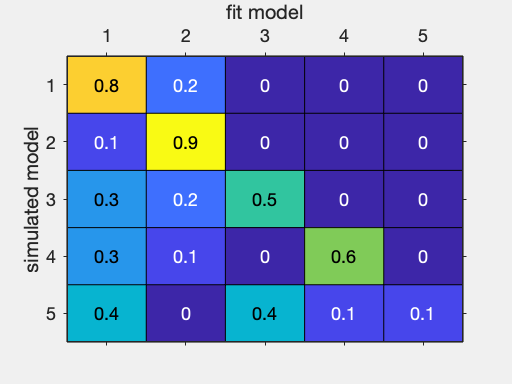

In [18]:
% plot the confusion matrix
figure(1); clf;
FM = round(100*CM/sum(CM(1,:)))/100;
t = imageTextMatrix(FM);
set(t(FM'<0.3), 'color', 'w')
hold on;
[l1, l2] = addFacetLines(CM);
set(t, 'fontsize', 18)
set(gca, 'xtick', [1:5], 'ytick', [1:5], 'fontsize', 18, ...
    'xaxislocation', 'top', 'tickdir', 'out')
xlabel('fit model')
ylabel('simulated model')

How does the confusion matrix change as you increase the number of trials in the simulation?

How does the confusion matrix change as you change the sampling distributions for the random parameter values?

# Take home message
* The best experiment design makes the computational processes identifiable in classical analyses of the behavioral data.
* A good computational model should be simple and interpretable.
* Conduct simulation before fitting real data. This will allow you to refine your experiment design and model design.